Zachary Loschinskey

December 2024

Code for the models discussed in Chapter 3 of Bayesian Filtering and Smotthing: Second Edition from Svensson and Sarkka

In [1]:
using Distributions
using Plots
using LinearAlgebra

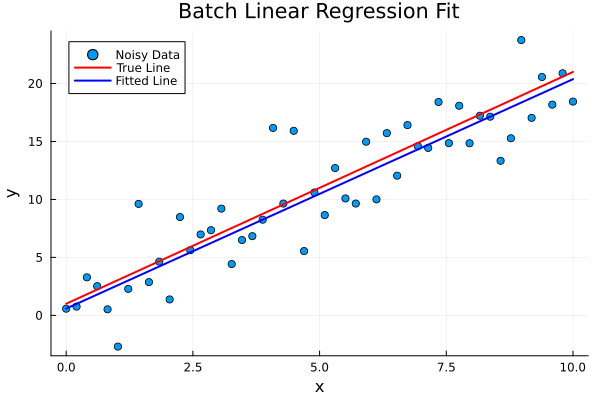

In [11]:
#=
Batch Linear Regression
A Bayesian approach to linear Regression
when you have a batch of data you would like
to fit.
=#

# Define the true parameters for the linear model
true_slope = 2.0
true_intercept = 1.0
noise_std = 3

# Generate the independent variable (x)
x = range(0, stop=10, length=50)

# Generate the dependent variable (y) with noise
y = true_slope .* x .+ true_intercept .+ rand(Normal(0, noise_std), length(x))

# Fit the Batch Linear Regression
# Design matrix
H = hcat(ones(length(x)),x)

# Define Priors -> small covariance prior can make prior more dominant
m0 = [0.0, 0.0]  # Assumes we don't have prior knowledge on sloe or intercept
p0 = Diagonal([0.5, 0.5])  # Larger covariance for less regularization

# Measurement noise covariance
R = noise_std^2 * I
R_inv = inv(R)

# Calculate posterior mean and covariance -> pg. 29: derivation in notebook
p0_inv = inv(p0)
pt = inv(p0_inv + R_inv*H'*H)
mt = pt*(R_inv*H'*y + p0_inv*m0)


# Extract estimated slope and intercept from posterior mean
intercept, slope = mt

# Predict using the model
y_pred = H*mt

# Visualize the data
scatter(x, y, label="Noisy Data", xlabel="x", ylabel="y", title="Batch Linear Regression Fit")
plot!(x, true_slope .* x .+ true_intercept, label="True Line", lw=2, color=:red)
plot!(x, y_pred, label="Fitted Line", lw=2, color=:blue)

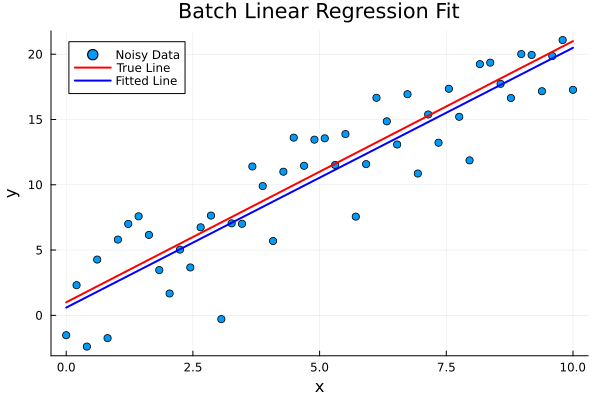

In [3]:
#=
Recursive Bayesian Regression
A Bayesian approach to linear regression
when more data is becoming available
over time

The idea is to take the same approach as in batch 
estimation, but now recursively replace the prior
with the posterior calculated on the previously
observed data points.
=#

# Same range and y values as before
x, y = x, y

# Design matrix -> But we are assuming we get this one row at a time
H = hcat(ones(length(x)),x)

# For simplicity, we will assume a constant, known measurement noise covariance
R = noise_std^2 * I
R_inv = inv(R)

# Define initial priors
m0 = [0.0, 0.0]
p0 = Diagonal([0.5, 0.5])

# Initialize posterior mean and covariance
m, p = m0, p0

#=
Note that the following equations come from using
the matrix inversion lemma on the posterior covariance
calculation from batch estimation. The reason this is done
is to create temporary variable Sₖ which needs to be inverted,
but is a scalar which reduces the computational power needed
to update the posterior with each new observation.

This is acutally a special case of the Kalman filter update equations
when the estimated parameters are assumed to be constant over time. Thus,
the prediction step is not necessary.
=#

# Recursively fit the model as we get each new Measurement
for i in 1:size(H,1)
    # Extract new observation
    H_new = H[i,:]'
    y_new = y[i]

    # Calculate temporary variables Sₖ and Kₖ
    S = H_new*p0*H_new' + R
    K = p0*H_new'*inv(S)            # Note that S is a scalar since we have 1 new observation

    # Calculate posterior mean and covariance
    m = m0 + K*(y_new - H_new*m0)
    p = p0 - K*S*K'

    # Set priors for next iteration equal to current posteriors
    m0, p0 = m, p
end

# Extract estimated slope and intercept from posterior mean
intercept_rec, slope_rec = m

# Predict using the model
y_pred_rec = H*m

# Visualize the data
scatter(x, y, label="Noisy Data", xlabel="x", ylabel="y", title="Batch Linear Regression Fit")
plot!(x, true_slope .* x .+ true_intercept, label="True Line", lw=2, color=:red)
plot!(x, y_pred_rec, label="Fitted Line", lw=2, color=:blue)

In [4]:
println("Note that the Batch and Recursive methods give the same parameter estimates given the same data!")
println("Batch Regression: Intercept = $(round(intercept, digits=5)), Slope = $(round(slope, digits=9))")
println("Recursive Regression: Intercept = $(round(intercept_rec, digits=5)), Slope = $(round(slope_rec, digits=9))")


Note that the Batch and Recursive methods give the same parameter estimates given the same data!
Batch Regression: Intercept = 0.59401, Slope = 1.989739065
Recursive Regression: Intercept = 0.59401, Slope = 1.989739065


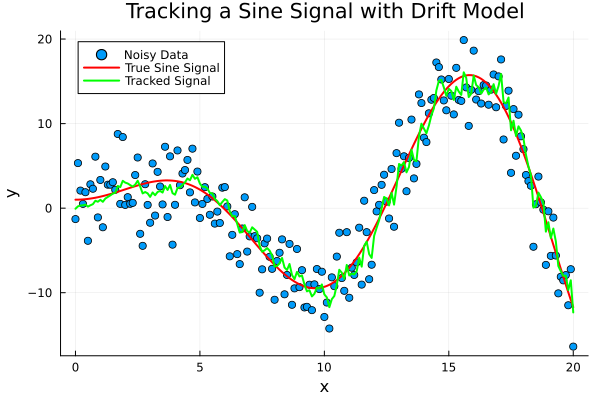

In [6]:
#=
Drift Model for Linear Regression
We will now let the parameters of the model
follow a random gaussian walk between each
observation, allowing for our linear model
to track nonlinear functions. In this example
I will show how this works for tracking a 
sine wave.

The only difference between this and the recursive
regression from before is that here we have the random
walk. Functionally, this means that in our mean and covariance
update steps, we need to add the gaussian random walk mean and
covariance. Since the mean is centered at the previous point, we
don't actually have to change the mean. The gaussian random walk
covariance is additive to the previous posterior covariance, so this
is really just addition.
=#

# Generate sine wave
noise_std = 3
x = 0:0.1:20
true_slope = sin.(x ./ 2)
true_intercept = cos.(x ./ 2)
y = true_slope .* x .+ true_intercept .+ noise_std .* randn(length(x))

# Design matrix: slope and intercept
H = hcat(ones(length(x)), x)

# Measurement noise covariance
R = noise_std^2 * I

# Drift covariance
Q = Diagonal([0.01, 0.01])


# Initial priors for the parameters (slope and intercept)
m0 = [0.0, 0.0]
p0 = Diagonal([0.5, 0.5])

# Recursive estimation
m_record = []
for i in 1:length(x)
    # Extract new observation
    H_new = H[i, :]'
    y_new = y[i]

    # Add gaussian walk covariance to prior
    # This looks like it might be (?) equivalent to the prediction step of Kalman filter equation.
    m_prior = m0
    p_prior = p0 + Q

    # Update step
    S = H_new * p_prior * H_new' + R
    K = p_prior * H_new' * inv(S)
    m = m_prior + K * (y_new - H_new * m_prior)
    p = p_prior - K * S * K'

    # Record results
    push!(m_record, m)

    # Set priors for next iteration
    m0, p0 = m, p
end

# Convert recorded means to array
m_record = hcat(m_record...)

# Predicted signal
y_pred_drift = [H[i, :]' * m_record[:, i] for i in 1:length(x)]

# Visualize the results
scatter(x, y, label="Noisy Data", xlabel="x", ylabel="y", title="Tracking a Sine Signal with Drift Model")
plot!(x, true_slope .* x .+ true_intercept, label="True Sine Signal", lw=2, color=:red)
plot!(x, y_pred_drift, label="Tracked Signal", lw=2, color=:lime)

#=
Note that we have to keep track of the estimated means
at each point of the recursion to reconstruct the signal at the end.
Unlike before, when we assumed the regression parameters were constant,
we do not just use the final posterior distribution to reconstruct the
signal.
=#

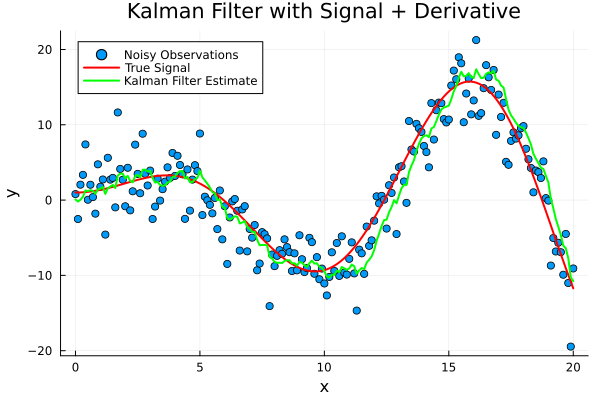

In [51]:
# Generate noisy sine wave observations
# Generate sine wave
noise_std = 3
x = 0:0.1:20
true_slope = sin.(x ./ 2)
true_intercept = cos.(x ./ 2)
y = true_slope .* x .+ true_intercept .+ noise_std .* randn(length(x))

# Time step
Δt = 0.1

# State transition matrix (signal + derivative)
#=
This dynamics matrix encodes the equations
x₁,ₖ = x₁,ₖ₋₁ + Δtₖ₋₁X₂,ₖ₋₁ + q₁,ₖ₋₁
x₂,ₖ = x₂,ₖ₋₁ + q₂,ₖ₋₁
yₖ = yₖ₋₁ + rₖ

Note that the first column of A says there is an x1 in the first equation
but not in the second. And that the second column says x2 is multiplied
by Δt in the first equation and 1 in the second.

H is a little confusing to me at the moment, but it is converting the
state vector into the observable, which in this case is just the signal,
or x₁. So thats why H = [1 0].
=#
A = [1.0 Δt; 0.0 1.0]

# Process noise covariance (Q)
Q = Diagonal([0.1, 0.1])

# Observation matrix (now includes intercept and slope terms)
H = [1.0 0.0]  # Only observing the signal (not the derivative)

# Measurement noise covariance (R)
R = noise_std^2

# Initial state estimate (mean and covariance)
m0 = [0.0, 0.0]  # Initial guess for signal and derivative
P0 = Diagonal([1.0, 1.0])  # Initial covariance

# Placeholder for storing results
state_means = []
state_covariances = []

# Kalman filter loop
m_prior = m0
P_prior = P0
for i in 1:length(x)

    y_obs = y[i]

    # --- Prediction Step ---
    m_pred = A * m_prior  # Predicted mean
    P_pred = A * P_prior * A' + Q  # Predicted covariance

    # --- Update Step ---
    S = H * P_pred * H' .+ R  # Innovation covariance (1x1)
    K = P_pred * H' / S      # Kalman gain (2x1)
    m_update = m_pred .+ K * (y_obs .- H * m_pred)  # Updated mean (2x1)
    P_update = P_pred - K * H * P_pred           # Updated covariance (2x2)


    # Store results
    push!(state_means, m_update)
    push!(state_covariances, P_update)

    # Update priors for next iteration
    m_prior, P_prior = m_update, P_update
end

# Convert recorded means to array
state_means = hcat(state_means...)

# Extract signal estimates
estimated_signal = state_means[1, :]  # First row is the signal

# Visualization
using Plots
scatter(x, y, label="Noisy Observations", xlabel="x", ylabel="y", title="Kalman Filter with Signal + Derivative")
plot!(x, true_slope .* x .+ true_intercept, label="True Signal", lw=2, color=:red)
plot!(x, estimated_signal, label="Kalman Filter Estimate", lw=2, color=:lime)
